<a href="https://colab.research.google.com/github/MJMortensonWarwick/AAMA/blob/main/3_0X_Statistical_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 3.01 Statistical EDA
This tutorial builds upon the previous Exploratory Data Analysis (EDA) tutorial by taking a closer look at key statistical measures and their interpretation, implemented using pandas, matplotlib, and seaborn. We'll focus not just on *how* to calculate these measures and create plots, but more importantly, on *what insights we can derive* from them.

In consuming this Notebook, do not panic too much about the code. Visualisation code can get very complicated and, unless visualisation is a key part of your role, is potentially not that critical. Much of this code I do not really remember to be able to write it perfectly without reference material. However, it is very common ... basically to every analytics and data science type project (meaning there are lots of examples on the internet (particularly in Python) and most GenAI tools perform well in this space. The seminar will help you use these tools to achieve the same goals. In other words, we are more interested in the process we follow and the interpretations we make, than the exact method of execution.

We'll start by importing our essential libraries and generating a synthetic dataset that mimics real-world complexities, including different distributions, missing values, and outliers. This allows us to clearly illustrate various statistical concepts.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Generate Synthetic Data
# We will create a bunch of fake data to work with
# Don't worry too much about the various distributions and so on!

np.random.seed(42) # for reproducability - same data each time
data_size = 1000 # 1000 records

data = {
    'Age': np.random.randint(18, 70, data_size), # Uniform distribution
    'Income': np.random.normal(loc=60000, scale=15000, size=data_size), # Normal distribution
    'ExperienceYears': np.random.poisson(lam=8, size=data_size), # Skewed (Poisson) distribution
    'CustomerRating': np.random.randint(1, 6, data_size), # Ordinal categorical
    'Region': np.random.choice(['North', 'South', 'East', 'West'], size=data_size), # Nominal categorical
    'PurchaseValue': np.random.gamma(shape=2, scale=300, size=data_size) # Skewed (Gamma) distribution
}

df = pd.DataFrame(data)

# Introduce missing values
df.loc[df.sample(frac=0.03).index, 'Income'] = np.nan
df.loc[df.sample(frac=0.01).index, 'ExperienceYears'] = np.nan

# Introduce some outliers
df.loc[df.sample(n=5).index, 'Income'] = np.random.uniform(200000, 500000, 5) # High income outliers
df.loc[df.sample(n=3).index, 'PurchaseValue'] = np.random.uniform(5000, 10000, 3) # Very high purchase outliers

print("DataFrame (Head)")
print(df.head())

print("\nDataFrame (Info)")
df.info()

DataFrame (Head)
   Age        Income  ExperienceYears  CustomerRating Region  PurchaseValue
0   56  35903.305196              9.0               3   West     409.474891
1   69  63051.954538              7.0               2   East     659.503553
2   46  48654.738821             10.0               2  South    1114.264537
3   32  38666.194356              9.0               4   West     404.160046
4   60  50301.406736             12.0               3   East     379.166829

DataFrame (Info)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              1000 non-null   int64  
 1   Income           970 non-null    float64
 2   ExperienceYears  990 non-null    float64
 3   CustomerRating   1000 non-null   int64  
 4   Region           1000 non-null   object 
 5   PurchaseValue    1000 non-null   float64
dtypes: float64(3), int64(2), object

## Univariate Analysis
Understanding the distribution and characteristics of each variable is the first crucial step. I.e. "univariate" meaning one variable. We'll examine measures of central tendency, dispersion, and distribution/shape (the main principles of descriptive statistics), and see how visualisations bring these numbers to life.

### Numerical Data: `Income` and `ExperienceYears`

Measures of Central Tendency (Mean, Median, Mode)
* **Mean:** The arithmetic average. Sensitive to extreme values (outliers).
* **Median:** The middle value when data is ordered. Robust to outliers.
* **Mode:** The most frequently occurring value. Useful for both numerical and categorical data, though less common for continuous numerical data due to many unique values.
**Interpretation:**
* If **Mean ≈ Median**, the data is likely symmetrically distributed.
* If **Mean > Median**, the data is likely right-skewed (positive skew), often indicating a long tail of higher values (e.g., incomes, prices).
* If **Mean < Median**, the data is likely left-skewed (negative skew), indicating a long tail of lower values (less common).

Let's look at `Income` and `ExperienceYears`.

In [ ]:
print("Income")
print(f"Mean Income: {round(df['Income'].mean(),2)}")
print(f"Median Income: {round(df['Income'].median(),2)}")
print(f"Mode Income: {round(df['Income'].mode()[0],2)} (first mode if multiple)")

print("\nExperienceYears")
print(f"Mean Experience: {round(df['ExperienceYears'].mean(),2)}")
print(f"Median Experience: {round(df['ExperienceYears'].median(),2)}")
print(f"Mode Experience: {round(df['ExperienceYears'].mode()[0],2)}")

Income
Mean Income: 62115.94
Median Income: 60842.81
Mode Income: 16556.17 (first mode if multiple)

ExperienceYears
Mean Experience: 7.9
Median Experience: 8.0
Mode Experience: 8.0


**Observations:**
* For `Income`, the mean is noticeably higher than the median, strongly suggesting a right-skewed distribution with some high-income outliers. The mode is quite different, hinting at a wider spread.
* For `ExperienceYears`, the mean is slightly higher than the median, also indicating a slight right-skew, which is typical for Poisson-distributed data (often used for counts like years of experience).

#### Measures of Dispersion (Spread: Std Dev, Variance, IQR, Range)
* **Standard Deviation (Std Dev):** Measures the average amount of variability or spread around the mean. A larger standard deviation indicates more spread.
* **Variance:** The square of the standard deviation. Less interpretable than Std Dev but fundamental for many statistical tests.
* **Interquartile Range (IQR):** The range between the 75th percentile (Q3) and the 25th percentile (Q1). It represents the middle 50% of the data and is robust to outliers.
* **Range:** The difference between the maximum and minimum values. Highly sensitive to outliers.
<br>

**Interpretation:**
* A large Std Dev relative to the mean suggests high variability, meaning data points are spread out.
* IQR provides a reliable measure of spread, especially useful when outliers are present, as it's not affected by the extreme values.

Let's calculate these.

In [ ]:
print("Income")
print(f"Std Dev Income: {round(df['Income'].std(),2)}")
print(f"Variance Income: {round(df['Income'].var(),2)}")
q1_income = df['Income'].quantile(0.25)
q3_income = df['Income'].quantile(0.75)
iqr_income = q3_income - q1_income
print(f"IQR Income: {round(iqr_income,2)} (Q1: {round(q1_income,2)}, Q3: {round(q3_income,2)})")
print(f"Range Income: {round(df['Income'].max() - df['Income'].min(),2)}")

print("\nExperienceYears")
print(f"Std Dev Experience: {round(df['ExperienceYears'].std(),2)}")
print(f"Variance Experience: {round(df['ExperienceYears'].var(),2)}")
q1_exp = df['ExperienceYears'].quantile(0.25)
q3_exp = df['ExperienceYears'].quantile(0.75)
iqr_exp = q3_exp - q1_exp
print(f"IQR Experience: {round(iqr_exp,2)} (Q1: {round(q1_exp,2)}, Q3: {round(q3_exp,2)})")
print(f"Range Experience: {round(df['ExperienceYears'].max() - df['ExperienceYears'].min(),2)}")

Income
Std Dev Income: 24182.27
Variance Income: 584782351.22
IQR Income: 19664.52 (Q1: 50801.26, Q3: 70465.79)
Range Income: 378863.94

ExperienceYears
Std Dev Experience: 2.6
Variance Experience: 6.75
IQR Experience: 4.0 (Q1: 6.0, Q3: 10.0)
Range Experience: 15.0


**Observations:**
* The `Income` has a very large standard deviation and range, primarily driven by the outliers we introduced. The IQR gives a more 'honest' view of the spread for the *majority* of the data.
* `ExperienceYears` has a smaller standard deviation and IQR, indicating a more concentrated spread, which is expected for counts.

#### Measures of Shape (Skewness, Kurtosis)
* **Skewness:** Measures the asymmetry of the probability distribution.
    * `> 0`: Right-skewed (positive skew, long tail to the right).
    * `< 0`: Left-skewed (negative skew, long tail to the left).
    * `≈ 0`: Symmetrical.
* **Kurtosis:** Measures the 'tailedness' of the distribution. It describes how much of the variance comes from infrequent extreme deviations (tails) versus frequent modest deviations (shoulders).
    * `> 0`: Leptokurtic (heavy tails, peaked center).
    * `< 0`: Platykurtic (light tails, flat center).
    * `≈ 0`: Mesokurtic (normal distribution like).

**Interpretation:** These values quantify what we often observe visually in histograms.

Let's calculate them.

In [ ]:
print("Income")
print(f"Skewness Income: {round(df['Income'].skew(),2)}")
print(f"Kurtosis Income: {round(df['Income'].kurt(),2)}")

print("\nExperienceYears")
print(f"Skewness Experience: {round(df['ExperienceYears'].skew(),2)}")
print(f"Kurtosis Experience: {round(df['ExperienceYears'].kurt(),2)}")

Income
Skewness Income: 7.32
Kurtosis Income: 87.31

ExperienceYears
Skewness Experience: 0.2
Kurtosis Experience: -0.15


**Observations:**
* `Income` has a very high positive skewness and kurtosis, confirming a highly right-skewed distribution with heavy tails (due to our outliers).
* `ExperienceYears` shows a moderate positive skew and a somewhat positive kurtosis, typical for a Poisson distribution that is not perfectly symmetrical and has somewhat heavier tails than a normal distribution.

#### Visualising Distributions
Histograms and Box plots are great for *seeing* the numbers we just calculated.
* **Histograms:** Show the frequency distribution of a numerical variable. They help visualize the shape, central tendency, and spread.
* **Box Plots:** Display the five-number summary (min, Q1, median, Q3, max) and clearly highlight potential outliers (points beyond the 'whiskers'). The whiskers typically extend to 1.5 * IQR from Q1 and Q3.

**Interpretation (Box Plot for Outliers):**
* The *box* itself represents the IQR (middle 50% of data).
* The *line* inside the box is the median.
* The *whiskers* show the typical range of data. Any points *outside* the whiskers are flagged as potential outliers. While statistically defined (1.5 * IQR rule), domain knowledge (i.e. an SME) is crucial to confirm if they are true anomalies or just extreme but valid values.

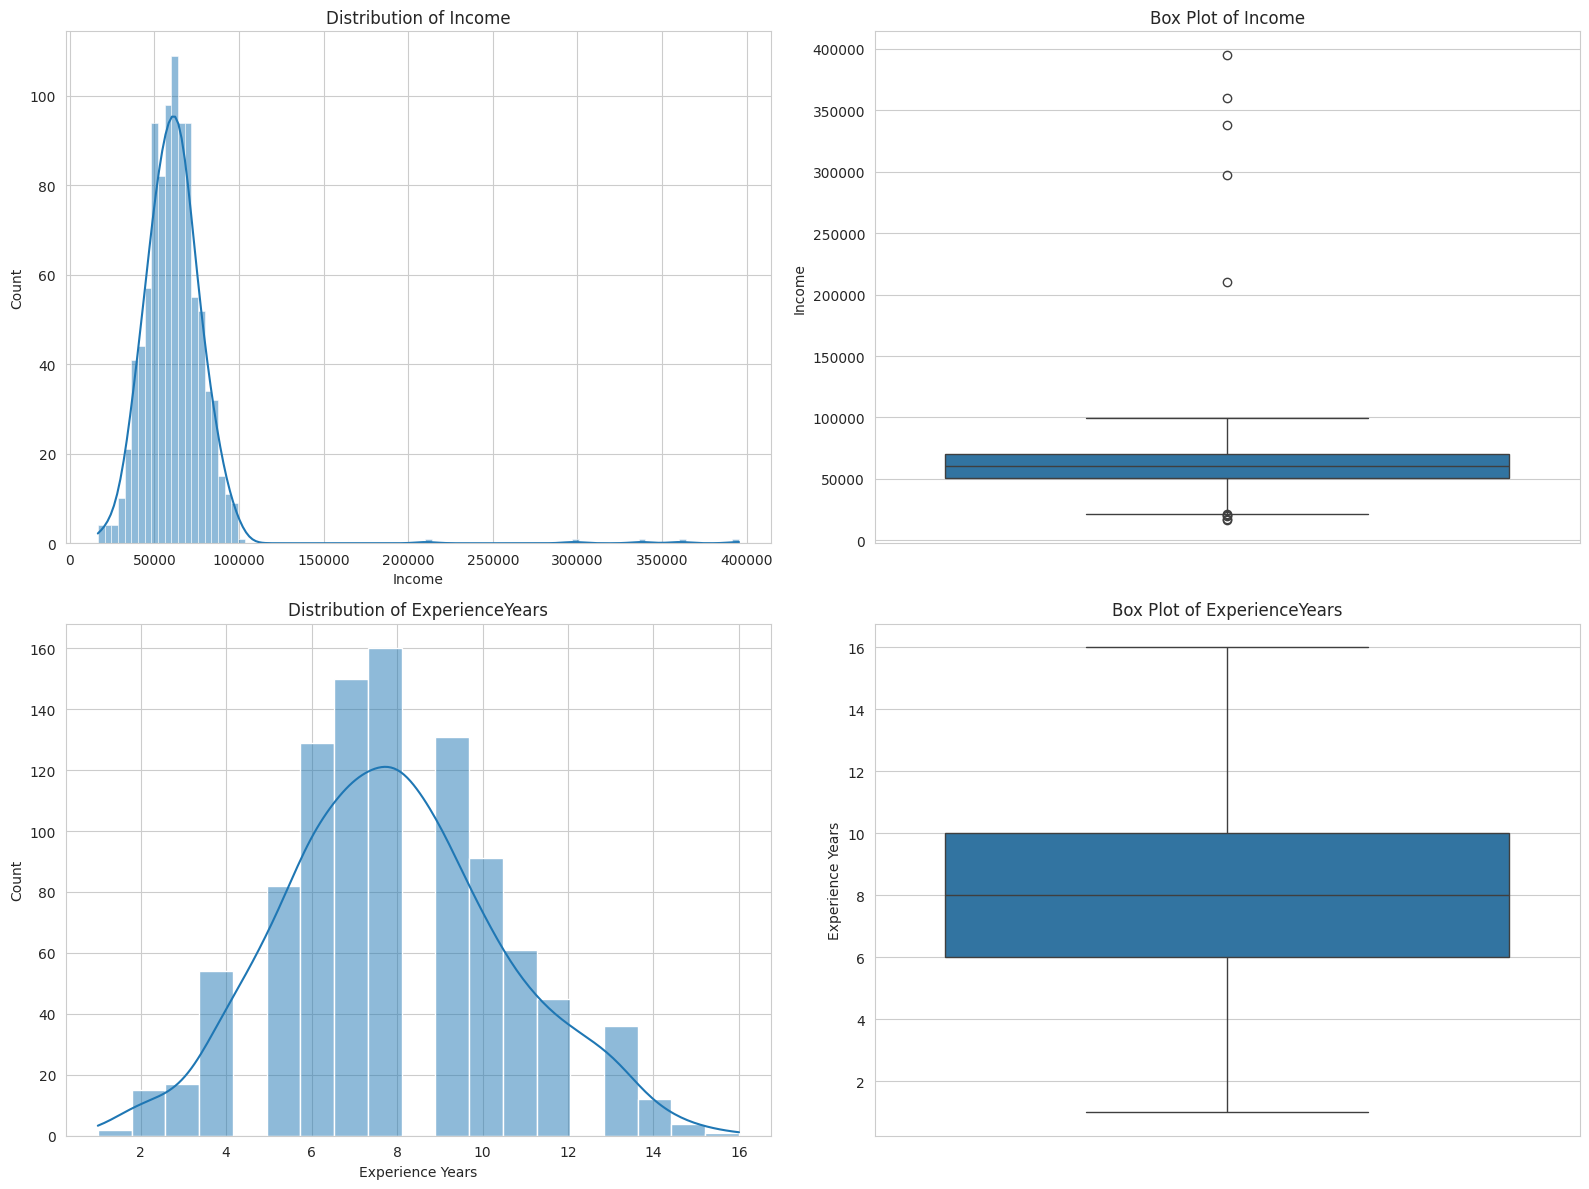

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Income Histplot
sns.histplot(df['Income'].dropna(), kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Income')
axes[0, 0].set_xlabel('Income')

# Income Boxplot
sns.boxplot(y=df['Income'].dropna(), ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Income')
axes[0, 1].set_ylabel('Income')

# ExperienceYears Histplot
sns.histplot(df['ExperienceYears'].dropna(), kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of ExperienceYears')
axes[1, 0].set_xlabel('Experience Years')

# ExperienceYears Boxplot
sns.boxplot(y=df['ExperienceYears'].dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of ExperienceYears')
axes[1, 1].set_ylabel('Experience Years')

plt.tight_layout()
plt.show()

**Visual Confirmation:**
* The Income histogram clearly shows a long tail to the right and the **boxplot** flags numerous points as outliers, confirming our earlier calculations.
The ExperienceYears histogram also shows a right skew, and the **boxplot** indicates a few potential outliers on the higher end, consistent with its Poisson distribution.

### Categorical Data: `CustomerRating` and `Region`For categorical data, we focus on counts and proportions.

#### Frequency Distribution
* **Value Counts:** How many times each unique category appears.
* **Percentages:** The proportion of each category.

**Interpretation:** Helps identify the most common categories, rare categories, and potential class imbalances (which can be important for machine learning).

In [ ]:
print("CustomerRating Value Counts")
print(df['CustomerRating'].value_counts())
print("\nCustomerRating Percentages")
print(df['CustomerRating'].value_counts(normalize=True).mul(100).round(2))

print("\nRegion Value Counts")
print(df['Region'].value_counts())
print("\nRegion Percentages")
print(df['Region'].value_counts(normalize=True).mul(100).round(2))

CustomerRating Value Counts
CustomerRating
2    218
4    208
5    201
3    198
1    175
Name: count, dtype: int64

CustomerRating Percentages
CustomerRating
2    21.8
4    20.8
5    20.1
3    19.8
1    17.5
Name: proportion, dtype: float64

Region Value Counts
Region
West     252
East     252
North    252
South    244
Name: count, dtype: int64

Region Percentages
Region
West     25.2
East     25.2
North    25.2
South    24.4
Name: proportion, dtype: float64


**Observations:**
* `CustomerRating` appears somewhat evenly distributed across the 1-5 scale, though '3' is slightly more common.
* `Region` is very evenly distributed, as expected from our synthetic data generation.

#### Visualising Categorical Data
Bar plots are the go-to for visualising frequency distributions of categorical variables.

/tmp/ipython-input-2523339016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CustomerRating', data=df, ax=axes[0], palette='viridis')
/tmp/ipython-input-2523339016.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Region', data=df, ax=axes[1], palette='magma')


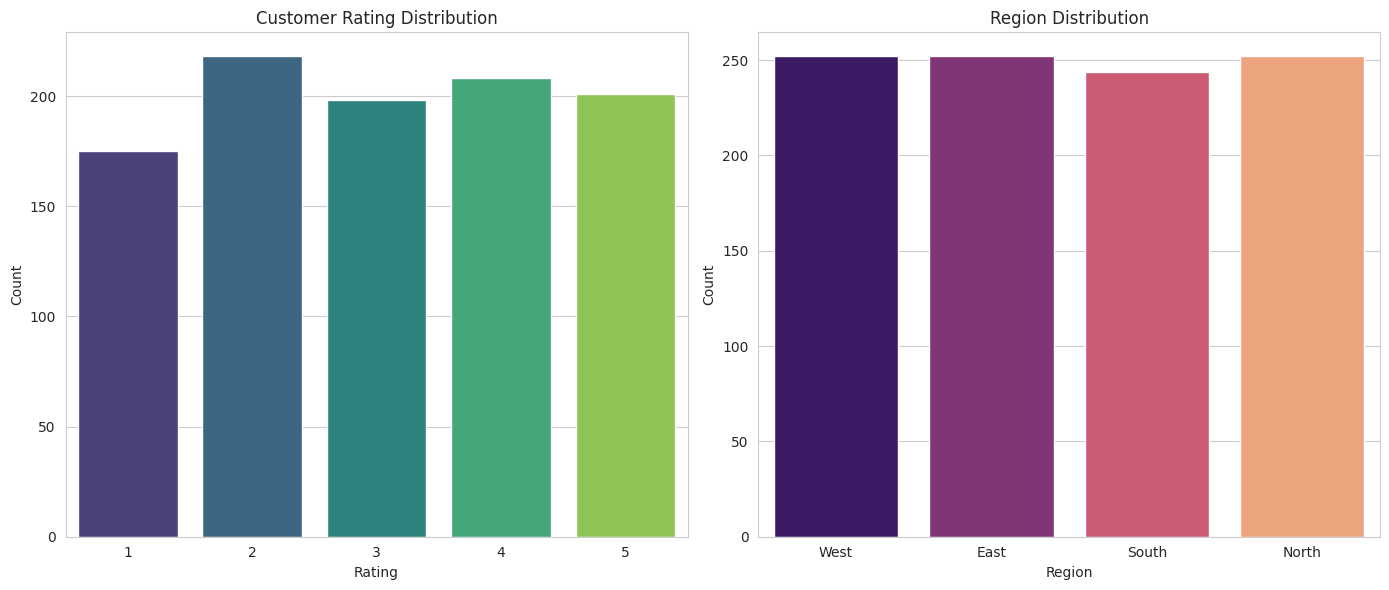

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x='CustomerRating', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Customer Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

sns.countplot(x='Region', data=df, ax=axes[1], palette='magma')
axes[1].set_title('Region Distribution')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()
# ignore the warning - it just says in some future version of the library they
# are changing who the code is written but for now its fine.

**Visual Confirmation:** The bar plots visually confirm the roughly even distribution we observed from the value counts.

## 3. Bivariate Analysis
Now we move from understanding individual variables (bi-variate) to seeing how they interact. This is where we start to uncover potential drivers or correlations.

### 3.1 Numerical vs. Numerical: `Income` vs. `PurchaseValue`
* **Pearson Correlation Coefficient ($r$):** Measures the strength and direction of a *linear* relationship between two numerical variables. Ranges from -1 (perfect negative linear) to +1 (perfect positive linear), with 0 indicating no linear relationship.
* **Spearman Rank Correlation Coefficient ($\rho$):** Measures the strength and direction of a *monotonic* relationship (not necessarily linear). Less sensitive to outliers and works for ordinal data.

**Interpretation:**
* A **high positive correlation** means as one variable increases, the other tends to increase.
* A **high negative correlation** means as one variable increases, the other tends to decrease.
* **Low correlation** suggests little to no linear/monotonic relationship. *Correlation does not imply causation!*
Let's check the correlation between `Income` and `PurchaseValue`.

In [ ]:
income_purchase_corr_pearson = df['Income'].corr(df['PurchaseValue'], method='pearson')
income_purchase_corr_spearman = df['Income'].corr(df['PurchaseValue'], method='spearman')

print(f"Pearson Correlation (Income vs. PurchaseValue): {round(income_purchase_corr_pearson,2)}")
print(f"Spearman Correlation (Income vs. PurchaseValue): {round(income_purchase_corr_spearman,2)}")

print("\nFull Numerical Correlation Matrix (Pearson)")
numerical_cols = ['Age', 'Income', 'ExperienceYears', 'PurchaseValue']
print(df[numerical_cols].corr(method='pearson').round(2))

Pearson Correlation (Income vs. PurchaseValue): -0.02
Spearman Correlation (Income vs. PurchaseValue): -0.0

Full Numerical Correlation Matrix (Pearson)
                  Age  Income  ExperienceYears  PurchaseValue
Age              1.00    0.01             0.00           0.01
Income           0.01    1.00             0.00          -0.02
ExperienceYears  0.00    0.00             1.00          -0.03
PurchaseValue    0.01   -0.02            -0.03           1.00


**Observations:**
* The Pearson correlation between `Income` and `PurchaseValue` is positive but relatively weak. This suggests a tendency for higher income to be associated with higher purchase value, but it's not a strong linear relationship. Spearman is slightly higher, suggesting a more consistent monotonic trend even if not perfectly linear.
* The full correlation matrix gives an overview of all pairwise linear relationships.

#### Visualising Numerical vs. Numerical
Scatter plots are indispensable for visualising the relationship between two numerical variables. They can reveal linear, non-linear, clustered, or no relationships, and also highlight bivariate outliers.

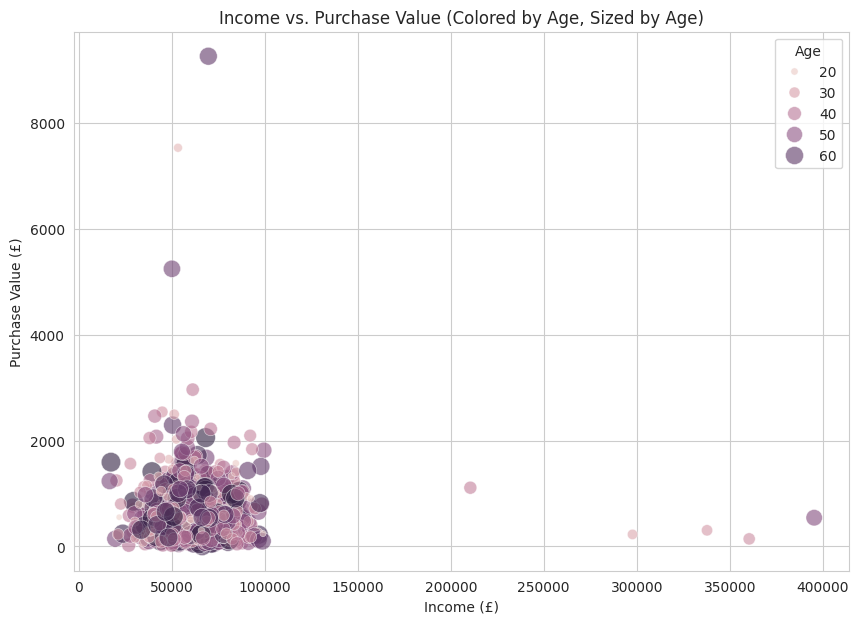

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Income', y='PurchaseValue', data=df, alpha=0.6, hue='Age', size='Age', sizes=(20, 200))
plt.title('Income vs. Purchase Value (Colored by Age, Sized by Age)')
plt.xlabel('Income (£)')
plt.ylabel('Purchase Value (£)')
plt.show()

**Visual Confirmation:**
* We can see a general upward trend, but also a lot of scatter, consistent with the moderate correlation. The high-income and high-purchase outliers are clearly visible in the upper-right corner.
* Adding `hue` and `size` parameters (e.g., based on `Age`) allows us to incorporate a third numerical variable, creating a *multivariate* view in a 2D plot. Here, it suggests some patterns related to age, but it's not a simple relationship.

### Categorical vs. Numerical: `Region` vs. `Income`
When comparing a numerical variable across different categories, we often look at group-wise statistics.

#### Group-wise Statistics
* Calculate the mean, median, standard deviation, etc., of the numerical variable for each category.

**Interpretation:** Helps identify if the numerical variable's central tendency or spread differs significantly across categories. This can suggest that the categorical variable is a significant predictor or factor for the numerical one.

In [ ]:
print("Income Statistics by Region")
print(df.groupby('Region')['Income'].agg(['mean', 'median', 'std']).reset_index().round(2)) # 2 decimal places

print("\nPurchaseValue Statistics by CustomerRating")
print(df.groupby('CustomerRating')['PurchaseValue'].agg(['mean', 'median', 'std']).reset_index().round(2))

Income Statistics by Region
  Region      mean    median       std
0   East  62606.27  60403.29  28345.57
1  North  61232.57  61073.49  23560.30
2  South  63025.37  60873.15  25735.13
3   West  61619.73  60891.37  17976.31

PurchaseValue Statistics by CustomerRating
   CustomerRating    mean  median     std
0               1  615.95  474.09  683.66
1               2  629.72  470.71  797.12
2               3  627.60  537.78  427.46
3               4  626.50  563.06  409.81
4               5  592.80  462.36  483.93


**Observations:**
* `Income` statistics appear somewhat similar across regions, though the 'mean' for 'East' is slightly higher, potentially due to random sampling or the presence of a few high outliers in that region (the 'median' is more consistent).
* For `PurchaseValue` by `CustomerRating`, there's a clear trend: higher customer ratings are associated with higher mean and median `PurchaseValue`. The standard deviation also increases with higher ratings, suggesting more variability in purchase values among highly-rated customers.

#### Visualising Categorical vs. Numerical
* **Box Plots:** Excellent for comparing the distribution (median, quartiles, outliers) of a numerical variable across different categories.
* **Violin Plots:** Similar to box plots but also show the kernel density estimate (KDE) of the distribution, giving a richer view of the data's shape at different values within each category.

**Interpretation:** These plots visually confirm group differences, identify if some categories have more outliers, or if their distributions have different shapes.

/tmp/ipython-input-1168081251.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region', y='Income', data=df, ax=axes[0], palette='pastel')
/tmp/ipython-input-1168081251.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='CustomerRating', y='PurchaseValue', data=df, ax=axes[1], palette='flare')


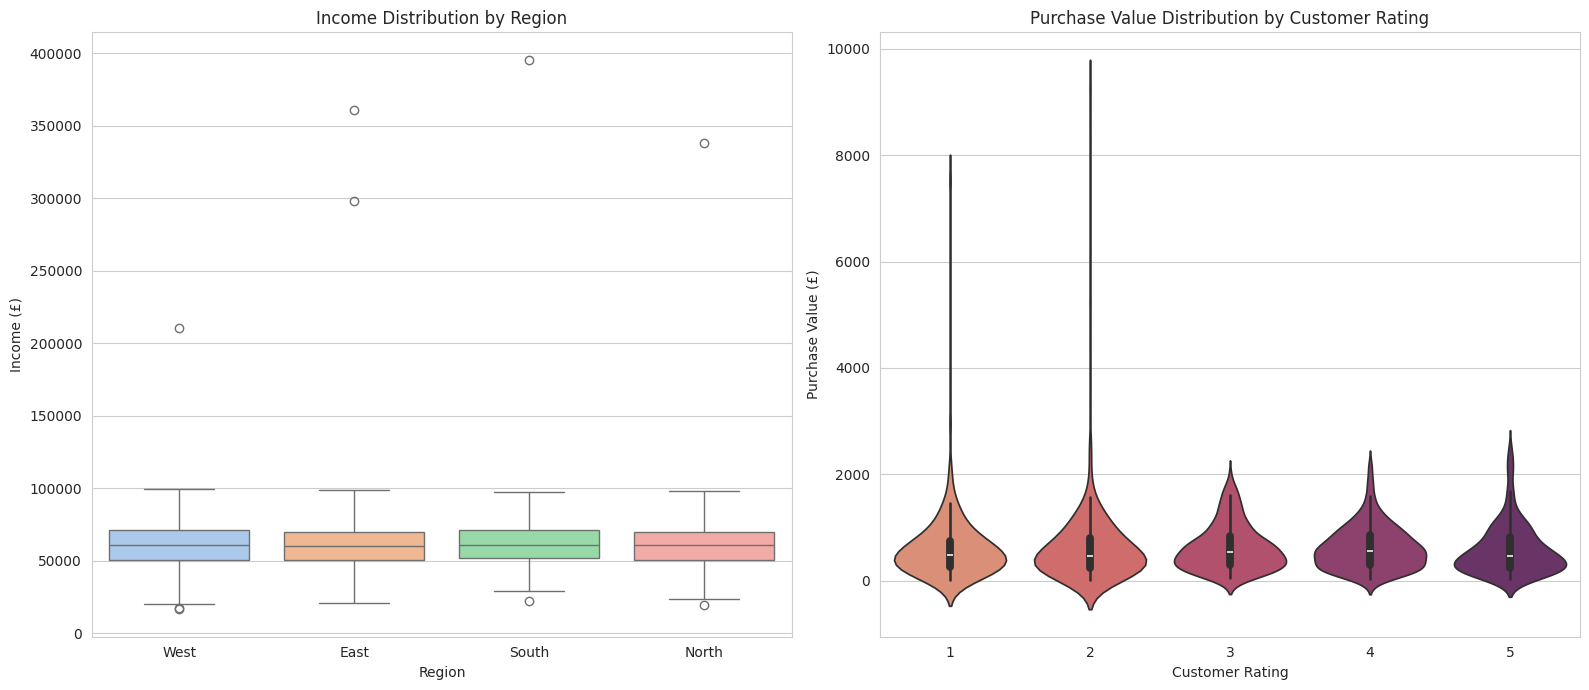

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Box plot of Income by Region
sns.boxplot(x='Region', y='Income', data=df, ax=axes[0], palette='pastel')
axes[0].set_title('Income Distribution by Region')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Income (£)')

# Violin plot of PurchaseValue by CustomerRating
sns.violinplot(x='CustomerRating', y='PurchaseValue', data=df, ax=axes[1], palette='flare')
axes[1].set_title('Purchase Value Distribution by Customer Rating')
axes[1].set_xlabel('Customer Rating')
axes[1].set_ylabel('Purchase Value (£)')

plt.tight_layout()
plt.show()

**Visual Confirmation:**
* The `Income` box plot by `Region` confirms that medians are quite close, but the spread and presence of outliers (especially in 'East') vary.
The `PurchaseValue` violin plot by `CustomerRating` beautifully illustrates the trend: as rating increases, the central tendency of purchase value also increases, and the distributions become wider, especially for rating '5'.

### Categorical vs. Categorical: `Region` vs. `CustomerRating`
To understand relationships between two categorical variables, we use cross-tabulations.

#### Cross-Tabulation (Contingency Tables)
* Counts the occurrences of each combination of categories.
* Can also show proportions (row-wise, column-wise, or total).

**Interpretation:** Helps identify if certain categories from one variable are disproportionately associated with categories from another. For example, are 'North' region customers more likely to give a '5' rating?

In [ ]:
print("Cross-tabulation: Region vs. CustomerRating (Counts)")
cross_tab_counts = pd.crosstab(df['Region'], df['CustomerRating'])
print(cross_tab_counts)

print("\nCross-tabulation: Region vs. CustomerRating (Row-wise Percentages)")
cross_tab_percent = pd.crosstab(df['Region'], df['CustomerRating'], normalize='index').mul(100).round(2)
print(cross_tab_percent)

Cross-tabulation: Region vs. CustomerRating (Counts)
CustomerRating   1   2   3   4   5
Region                            
East            39  50  47  57  59
North           50  53  53  44  52
South           49  58  43  49  45
West            37  57  55  58  45

Cross-tabulation: Region vs. CustomerRating (Row-wise Percentages)
CustomerRating      1      2      3      4      5
Region                                           
East            15.48  19.84  18.65  22.62  23.41
North           19.84  21.03  21.03  17.46  20.63
South           20.08  23.77  17.62  20.08  18.44
West            14.68  22.62  21.83  23.02  17.86


**Observations:**
* The count table shows the raw numbers. The percentage table is more informative: it shows, for example, what percentage of customers *in each region* give a certain rating.
* Here, the distributions of ratings across regions look quite similar, confirming that our synthetic data doesn't have a strong relationship between region and customer rating.

#### Visualising Categorical vs. Categorical
* **Stacked/Grouped Bar Charts:** Visually compare the distributions.
* **Heatmaps:** Excellent for cross-tabulations, especially when there are many categories, making it easy to spot patterns from color intensity.

**Interpretation:** Heatmaps quickly reveal which combinations of categories are most or least frequent.

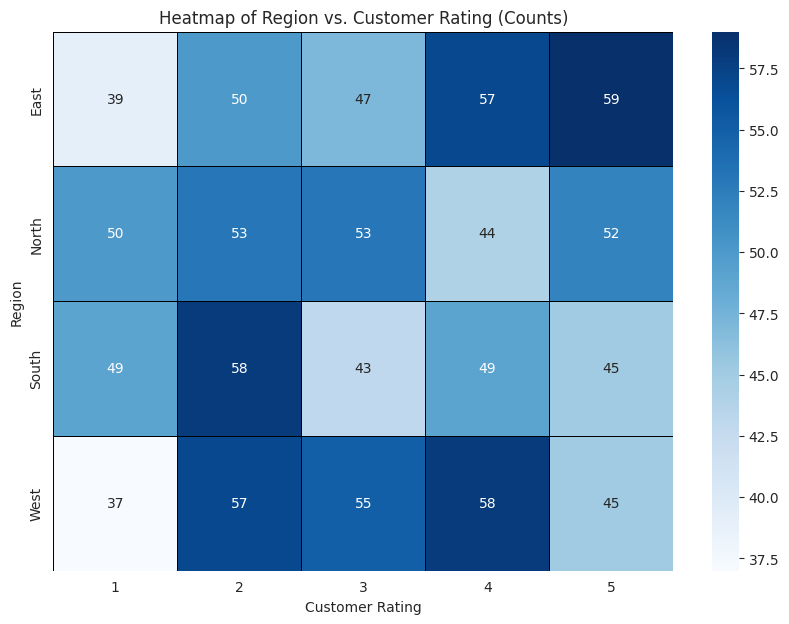

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(cross_tab_counts, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='black')
plt.title('Heatmap of Region vs. Customer Rating (Counts)')
plt.xlabel('Customer Rating')
plt.ylabel('Region')
plt.show()

**Visual Confirmation:** The heatmap clearly shows that counts are quite uniform across all combinations, reinforcing the lack of a strong relationship between `Region` and `CustomerRating` in our dataset.

## 4. Multivariate Analysis
While basic EDA often focuses on univariate and bivariate analysis, real-world data involves multiple interacting variables. Multivariate analysis helps us see these interactions.

### Pair Plots
A `seaborn.pairplot` creates a grid of plots: histograms for each variable on the diagonal and scatter plots for all pairwise combinations of numerical variables off the diagonal. It's a quick way to get an overview of multiple relationships.

**Interpretation:** A single pair plot can quickly reveal distributions, correlations, and potential clusters or outliers across many variables at once. Adding `hue` allows us to see how a categorical variable influences these pairwise relationships.

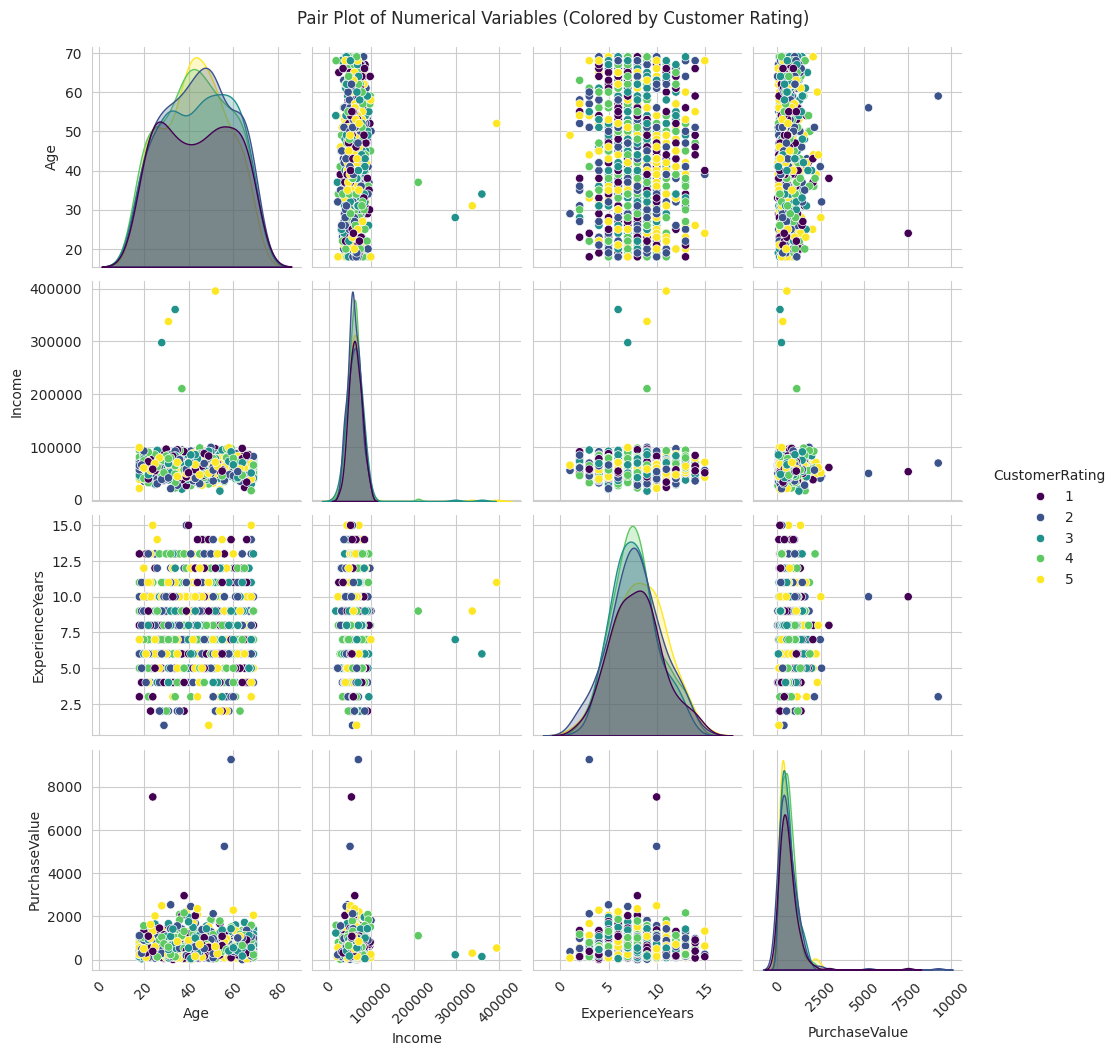

In [ ]:
numerical_cols_for_pairplot = ['Age', 'Income', 'ExperienceYears', 'PurchaseValue']
# Include 'CustomerRating' in the DataFrame before dropping NA values
cols_for_pairplot = numerical_cols_for_pairplot + ['CustomerRating']
filtered_df = df[cols_for_pairplot].dropna()
g = sns.pairplot(filtered_df, hue='CustomerRating', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot of Numerical Variables (Colored by Customer Rating)', y=1.02) # Adjust suptitle position

# Rotate axis labels for better readability
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.show()

**Visual Confirmation:** This plot provides a rich summary. For instance, notice how `Income` and `PurchaseValue` distributions on the diagonal are right-skewed. The scatter plots between `Income` and `PurchaseValue` show the positive trend, and importantly, the `hue` for `CustomerRating` *starts* to show how different ratings might distribute across these values (e.g., higher ratings tending towards higher purchase values).

### Conditional Plots
(Facet Grids)`seaborn`'s `FacetGrid` (or direct use of `col`/`row` parameters in many `seaborn` plots) allows splitting a plot into multiple subplots based on the values of one or more categorical variables.

**Interpretation:** This helps identify if relationships or distributions change significantly depending on the category. For example, does the relationship between `Income` and `PurchaseValue` differ by `Region`?

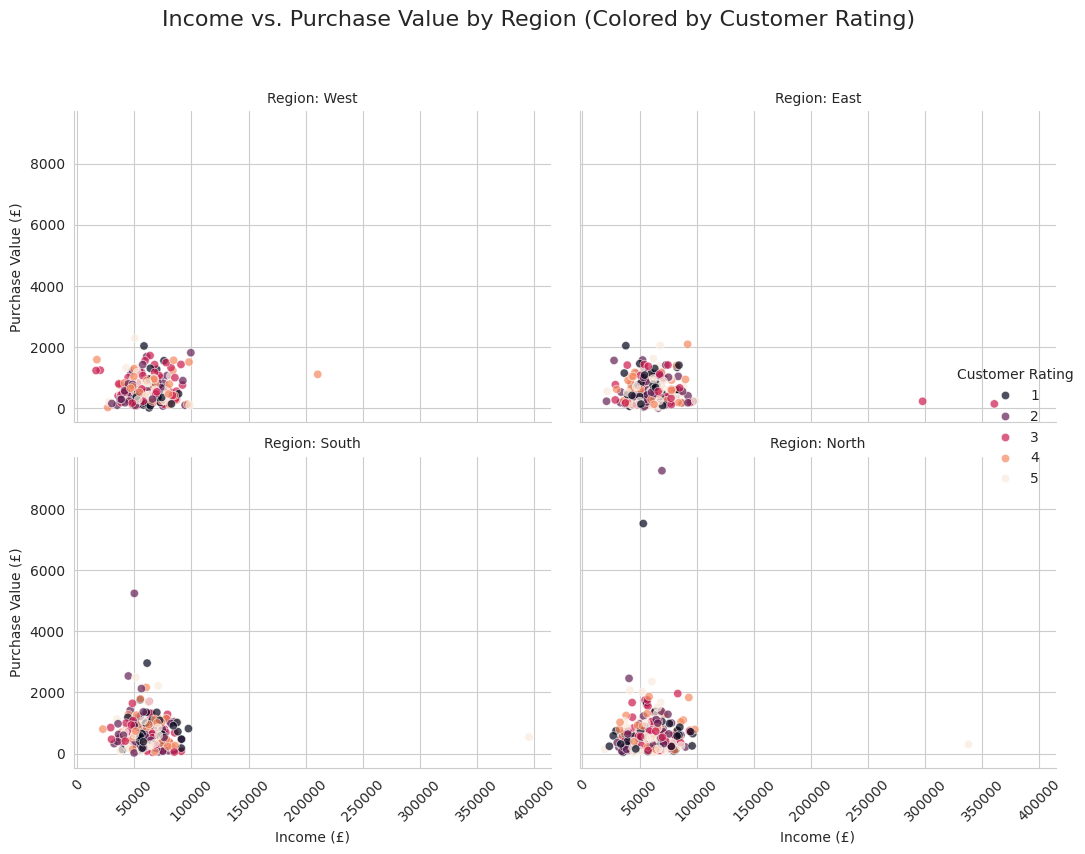

In [ ]:
g = sns.FacetGrid(df, col='Region', col_wrap=2, height=4, aspect=1.2)
g.map_dataframe(sns.scatterplot, x='Income', y='PurchaseValue', hue='CustomerRating', palette='rocket', alpha=0.7)
g.add_legend(title='Customer Rating')
g.set_axis_labels('Income (£)', 'Purchase Value (£)')
g.set_titles(col_template='Region: {col_name}')
plt.suptitle('Income vs. Purchase Value by Region (Colored by Customer Rating)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
plt.show()

**Visual Confirmation:** Here we can see how the `Income` vs `PurchaseValue` scatter plot, further colored by `CustomerRating`, looks different in each `Region`. In our synthetic data, the patterns remain generally consistent, but in real data, you might discover distinct regional behaviors!

## 5. Outlier Detection
We saw outliers in box plots. Let's quantify them using the IQR method and understand their implications.

#### IQR Method for Outlier DetectionThis method defines outliers as values falling outside specific 'fences':
* **Lower Fence:** Q1 - 1.5 * IQR
* **Upper Fence:** Q3 + 1.5 * IQR

**Interpretation:** This provides a statistical definition of 'extreme' values. Outliers can represent data entry errors, rare but valid events, or significant anomalies. Their presence can heavily influence means, standard deviations, and many machine learning models, so identifying them is crucial.

In [ ]:
def find_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

income_outliers, income_lower, income_upper = find_iqr_outliers(df['Income'].dropna())
purchase_outliers, purchase_lower, purchase_upper = find_iqr_outliers(df['PurchaseValue'].dropna())

print(f"Income Outliers (Count: {len(income_outliers)}):\n{income_outliers.round(2)}")
print(f"\nIncome Lower Bound: {income_lower:,.2f}, Upper Bound: {income_upper:,.2f}")

print(f"\nPurchaseValue Outliers (Count: {len(purchase_outliers)}):\n{purchase_outliers.round(2)}")
print(f"\nPurchaseValue Lower Bound: {purchase_lower:,.2f}, Upper Bound: {purchase_upper:,.2f}")

Income Outliers (Count: 10):
62     395420.11
80     337803.91
164     19546.70
186     20235.45
253    297730.44
579     17271.86
583    360471.44
619     16556.17
873     21134.37
908    210526.28
Name: Income, dtype: float64

Income Lower Bound: 21,304.48, Upper Bound: 99,962.57

PurchaseValue Outliers (Count: 35):
39     2054.81
41     1674.42
112    1722.32
113    2020.95
124    1646.34
135    2217.49
146    1688.59
152    2539.69
190    1752.06
202    2072.82
254    1723.82
273    1817.18
311    2461.05
342    7524.80
446    1963.97
478    9252.61
510    1663.31
533    1701.52
541    2092.63
555    2046.68
600    1762.31
632    1679.70
664    1669.03
670    2290.69
725    5240.75
747    1836.54
759    1754.14
760    2494.83
784    1868.07
812    2960.33
813    2037.85
824    2163.00
835    1789.46
934    2357.50
954    2125.24
Name: PurchaseValue, dtype: float64

PurchaseValue Lower Bound: -563.50, Upper Bound: 1,645.84


**Observations:** We've successfully identified the exact values that were flagged as outliers in the box plots. Now, a human data scientist would investigate these. Are these data entry errors that need correction? Or are they genuinely rare, high-value customers that represent a distinct segment? The answer guides how to handle them (remove, transform, or keep).

## 6. Missing Value Analysis
We saw `df.info()` show missing values. Let's visualise their patterns.

#### Visualising Missingness
A heatmap can show the distribution of missing values across the dataset. This is important because the *pattern* of missingness can tell you a lot.

* **Missing Completely at Random (MCAR):** No identifiable pattern.
* **Missing at Random (MAR):** Missingness depends on other observed variables.
* **Missing Not at Random (MNAR):** Missingness depends on the unobserved value itself.

**Interpretation:** Understanding the pattern guides imputation strategies. For MCAR/MAR, simple imputation methods (mean/median/mode) or more sophisticated techniques might be appropriate. For MNAR, imputation is much harder, and the missingness itself might be a valuable signal.

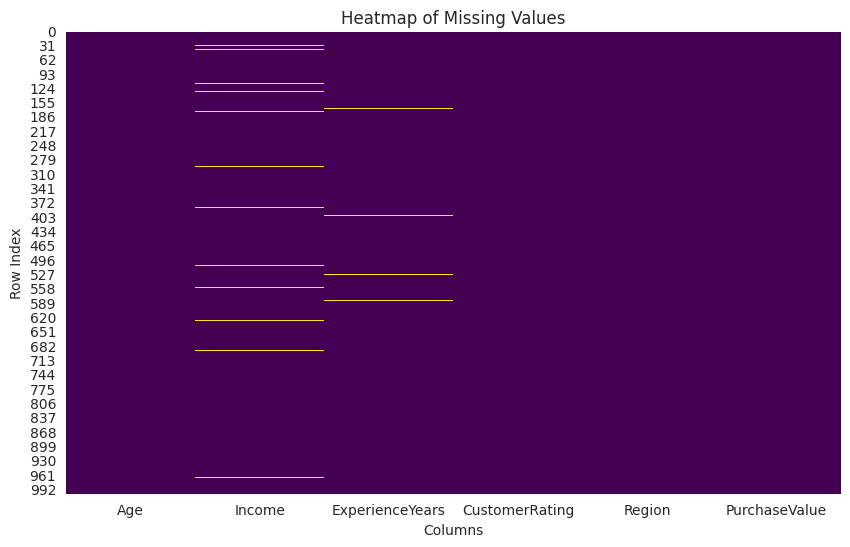

--- Percentage of Missing Values ---
Age                0.0
Income             3.0
ExperienceYears    1.0
CustomerRating     0.0
Region             0.0
PurchaseValue      0.0
dtype: float64


In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.ylabel('Row Index')
plt.xlabel('Columns')
plt.show()

print("--- Percentage of Missing Values ---")
print(df.isnull().sum() / len(df) * 100)

**Observations:** The heatmap visually confirms where the missing values are concentrated (in `Income` and `ExperienceYears`). In our synthetic case, they are scattered randomly, suggesting MCAR. In real data, you might see clear blocks or rows of missingness, indicating a systematic issue.

## 7. Conclusion
Statistical EDA is an iterative process that combines quantitative measures with powerful visualisations to extract meaningful insights from data. It's not just about crunching numbers or drawing plots; it's about asking questions, forming hypotheses, and using statistics to find answers.

### Takeaways:
* **Mean vs. Median:** Crucial for understanding skewness and the impact of outliers.
* **Standard Deviation vs. IQR:** Both measure spread, but IQR is more robust to outliers.
* **Skewness/Kurtosis:** Quantify the shape of distributions.
* **Box Plots:** Excellent for quickly identifying central tendency, spread, and outliers in numerical data.
* **Histograms & Bar Charts:** Visualising distributions for numerical and categorical data, respectively.
* **Correlation:** Quantifies linear/monotonic relationships between numerical variables.
* **Scatter Plots:** The go-to for visualising bivariate numerical relationships and spotting patterns/outliers.
* **Group-wise Aggregations & Violin Plots:** Powerful for comparing numerical distributions across categories.
* **Cross-tabulations & Heatmaps:** Essential for understanding relationships between categorical variables.
* **Outlier & Missing Value Analysis:** Not just about detection, but also about *interpreting their meaning* in the context of your data and domain knowledge.

Remember, EDA is a conversation between you and your data. These tools are your language for that conversation. However, they get very complicated (code-wise) very fast. In the second part of the session we will see how AI gets on with it!